In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [7]:
df=pd.read_csv(os.path.join('datasets','spam.csv'), encoding='ISO-8859-1')

In [8]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [13]:
df=df[df.columns[:2]]

In [14]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
df.shape

(5572, 2)

In [18]:
texts=df['v2'].values

In [19]:
texts

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       ..., 'Pity, * was in mood for that. So...any other suggestions?',
       "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free",
       'Rofl. Its true to its name'], dtype=object)

In [20]:
from tensorflow.keras.layers import TextVectorization

In [21]:
MAX_FEATURES=200000

In [22]:
vectorizer=TextVectorization(max_tokens=MAX_FEATURES,output_sequence_length=1800,output_mode='int')

In [23]:
vectorizer.adapt(texts)

In [27]:
len(vectorizer.get_vocabulary())

9564

In [28]:
vectorized_text=vectorizer(texts)

In [29]:
vectorized_text

<tf.Tensor: shape=(5572, 1800), dtype=int64, numpy=
array([[  47,  445, 7000, ...,    0,    0,    0],
       [  49,  316, 1504, ...,    0,    0,    0],
       [  51,  469,   10, ...,    0,    0,    0],
       ...,
       [6077,   62,   10, ...,    0,    0,    0],
       [   6,  500,  111, ...,    0,    0,    0],
       [2391,   42,  478, ...,    0,    0,    0]], dtype=int64)>

In [63]:
y=df['v1'].map({'ham':0,'spam':1})

In [64]:
y=y.values

In [65]:
# y=np.expand_dims(y,0)

In [66]:
y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [67]:
#MCSHBAP
dataset=tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset=dataset.cache()
dataset=dataset.shuffle(100)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8)

In [68]:
train=dataset.take(int(len(dataset)*.7))
val=dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test=dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Bidirectional,LSTM,Embedding

In [136]:
model=Sequential()
model.add(Embedding(MAX_FEATURES+1,32))
model.add(Bidirectional(LSTM(32,activation='tanh')))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [137]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [138]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_36 (Dense)            (None, 128)               8320      
                                                                 
 dense_37 (Dense)            (None, 256)               33024     
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                                 
 dense_39 (Dense)            (None, 1)                 129       
                                                      

In [140]:
history=model.fit(train,epochs=8,validation_data=val)

Epoch 1/8
244/244 [==============================] - 354s 1s/step - loss: 0.1503 - accuracy: 0.9462 - val_loss: 0.0676 - val_accuracy: 0.9783
Epoch 2/8
244/244 [==============================] - 325s 1s/step - loss: 0.0276 - accuracy: 0.9926 - val_loss: 0.0699 - val_accuracy: 0.9746
Epoch 3/8
244/244 [==============================] - 237s 971ms/step - loss: 0.0075 - accuracy: 0.9972 - val_loss: 0.0748 - val_accuracy: 0.9783
Epoch 4/8
244/244 [==============================] - 244s 1s/step - loss: 3.6969e-04 - accuracy: 1.0000 - val_loss: 0.1032 - val_accuracy: 0.9783
Epoch 5/8
244/244 [==============================] - 247s 1s/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0973 - val_accuracy: 0.9855
Epoch 6/8
244/244 [==============================] - 251s 1s/step - loss: 1.3335e-05 - accuracy: 1.0000 - val_loss: 0.1139 - val_accuracy: 0.9873
Epoch 7/8
244/244 [==============================] - 1950s 8s/step - loss: 4.2349e-06 - accuracy: 1.0000 - val_loss: 0.1316 - val_accurac

In [141]:
import matplotlib.pyplot as plt

<Figure size 800x500 with 0 Axes>

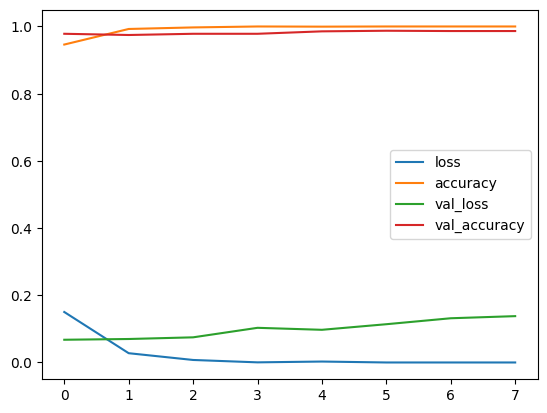

In [142]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [147]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [148]:
pre=Precision()
rec=Recall()
ba=BinaryAccuracy()

In [176]:
for batch in train.as_numpy_iterator():
    X_true,y_true=batch
    yhat=model.predict(X_true)
    yhat=(yhat>=0.5).astype(int)
    yhat=yhat.flatten()
    y_true=y_true.flatten()
    
    # print(accuracy_score(y_true,yhat))
    
    pre.update_state(yhat,y_true)
    rec.update_state(yhat,y_true)
    ba.update_state(yhat,y_true)

1/1 [==============================] - 0s 288ms/step


In [177]:
print(f'Precision {pre.result().numpy()}, Recall {rec.result().numpy()}, Accuracy {ba.result().numpy()}')

Precision 0.9995169043540955, Recall 0.3795633912086487, Accuracy 0.7793288826942444


In [165]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [167]:
X_test,y_test=test.as_numpy_iterator().next()

In [168]:
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 332ms/step


In [169]:
y_pred=(y_pred>=0.5).astype(int)

In [170]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]])

In [171]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [172]:
confusion_matrix(y_pred,y_test)

array([[15,  0],
       [ 0,  1]], dtype=int64)

In [173]:
accuracy_score(y_pred,y_test)

1.0